In [1]:
#learning_rate=0.0001
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './TCIA_new_splitted'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
test_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './TCIA_new_splitted'
test_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          test_transforms[x])
                  for x in ['test']}
testloaders = {x: torch.utils.data.DataLoader(test_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['test']}
testset_sizes = {x: len(test_datasets[x]) for x in ['test']}
class_names = test_datasets['test'].classes

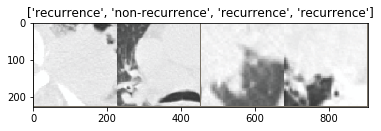

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss=[]
    val_loss=[]
    test_loss=[]
    train_acc=[]
    val_acc=[]
    test_acc=[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val','test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase=='train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            elif phase=='val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
            else:
                test_loss.append(epoch_loss)
                test_acc.append(epoch_acc)
            #print(phase,train_loss,val_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    plt.title('model loss')
    plt.plot(train_loss,'r',val_loss,'g',test_loss,'b')
    plt.legend(['train','val','test'])
    plt.show()
    plt.title('model accuracy')
    plt.plot(train_acc,'r',val_acc,'g',test_acc,'b')
    plt.legend(['train','val','test'])
    plt.show()
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,best_acc

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
def visualize_model2(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
            
                    return
                model.train(mode=was_training)

In [8]:
def test_acc(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloaders['test']:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Testset Accuracy: %d %%' % (100 * correct / total))
    return correct / total

In [9]:
learning_rate=0.0001

In [10]:
val_bestacc=[]
test_bestacc=[]

In [11]:
#fine-tuning 1-7 layer
model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
#print(num_ftrs)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to  nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[6] = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/24
----------
train Loss: 0.7735 Acc: 0.5385
val Loss: 0.7114 Acc: 0.6667
test Loss: 0.5635 Acc: 0.7000

Epoch 1/24
----------
train Loss: 0.6813 Acc: 0.6769
val Loss: 0.7790 Acc: 0.4000
test Loss: 0.6099 Acc: 0.7000

Epoch 2/24
----------
train Loss: 0.5851 Acc: 0.6769
val Loss: 0.8490 Acc: 0.4667
test Loss: 0.5825 Acc: 0.5500

Epoch 3/24
----------
train Loss: 0.6491 Acc: 0.6615
val Loss: 0.8539 Acc: 0.5333
test Loss: 0.6195 Acc: 0.6500

Epoch 4/24
----------
train Loss: 0.6322 Acc: 0.7231
val Loss: 0.7088 Acc: 0.6667
test Loss: 0.6060 Acc: 0.6500

Epoch 5/24
----------
train Loss: 0.5735 Acc: 0.7846
val Loss: 0.8195 Acc: 0.4000
test Loss: 0.6108 Acc: 0.6500

Epoch 6/24
----------
train Loss: 0.6175 Acc: 0.6615
val Loss: 0.7997 Acc: 0.4667
test Loss: 0.6440 Acc: 0.6500

Epoch 7/24
----------
train Loss: 0.5417 Acc: 0.7385
val Loss: 0.7843 Acc: 0.4667
test Loss: 0.6233 Acc: 0.6000

Epoch 8/24
----------
train Loss: 0.5723 Acc: 0.7385
val Loss: 0.7854 Acc: 0.4667
test Loss: 0.6

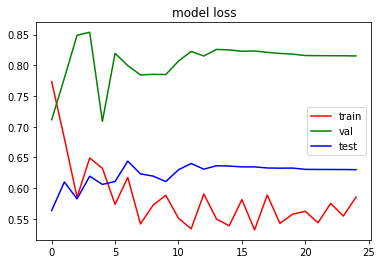

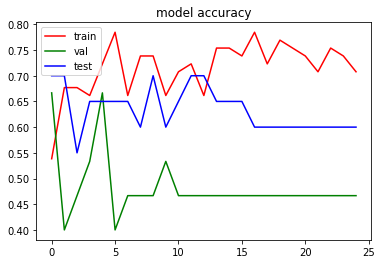

In [12]:
model_ft,best_acc0 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
val_bestacc.append(best_acc0)

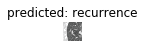

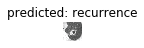

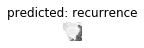

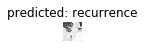

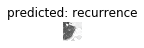

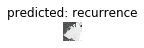

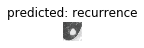

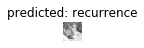

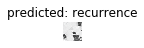

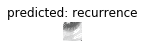

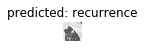

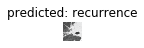

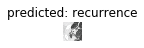

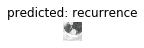

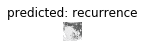

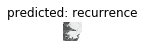

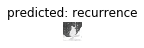

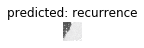

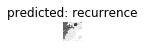

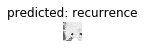

In [13]:
visualize_model2(model_ft, num_images=20)

In [14]:
test_bestacc0=test_acc(model_ft)
test_bestacc.append(test_bestacc0)

Testset Accuracy: 70 %


In [15]:
conv_layer=[]
for cnt in range(len(model_ft.features)):
    for param in model_ft.features[cnt].parameters():
        conv_layer.append(cnt)
conv_layer=list(set(conv_layer))

In [16]:
conv_layer

[0, 3, 6, 8, 10]

In [17]:
#freeze 1 conv layer
model_conv1 = torchvision.models.alexnet(pretrained=True)
for cnt in range(conv_layer[0]+1):
    for param in model_conv1.features[cnt].parameters():
        param.requires_grad = False
        print(cnt,model_conv1.features[cnt],': freeze')

num_ftrs = model_conv1.classifier[6].in_features
model_conv1.classifier[6] = nn.Linear(num_ftrs, 2)

model_conv1 = model_conv1.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, model_conv1.parameters()), lr=learning_rate, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)) : freeze
0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)) : freeze


Epoch 0/24
----------
train Loss: 0.6874 Acc: 0.6308
val Loss: 0.7115 Acc: 0.6667
test Loss: 0.6631 Acc: 0.6500

Epoch 1/24
----------
train Loss: 0.6166 Acc: 0.6769
val Loss: 0.6764 Acc: 0.6000
test Loss: 0.6747 Acc: 0.6000

Epoch 2/24
----------
train Loss: 0.5986 Acc: 0.6923
val Loss: 0.5872 Acc: 0.7333
test Loss: 0.6730 Acc: 0.5500

Epoch 3/24
----------
train Loss: 0.6409 Acc: 0.7231
val Loss: 0.7062 Acc: 0.6000
test Loss: 0.7101 Acc: 0.4500

Epoch 4/24
----------
train Loss: 0.5656 Acc: 0.7538
val Loss: 0.7330 Acc: 0.5333
test Loss: 0.6817 Acc: 0.6500

Epoch 5/24
----------
train Loss: 0.5628 Acc: 0.6923
val Loss: 0.8579 Acc: 0.4000
test Loss: 0.8375 Acc: 0.5000

Epoch 6/24
----------
train Loss: 0.7211 Acc: 0.5385
val Loss: 0.7705 Acc: 0.6667
test Loss: 0.6831 Acc: 0.7000

Epoch 7/24
----------
train Loss: 0.6155 Acc: 0.6923
val Loss: 0.7408 Acc: 0.6667
test Loss: 0.6674 Acc: 0.7000

Epoch 8/24
----------
train Loss: 0.6275 Acc: 0.6923
val Loss: 0.7073 Acc: 0.6000
test Loss: 0.6

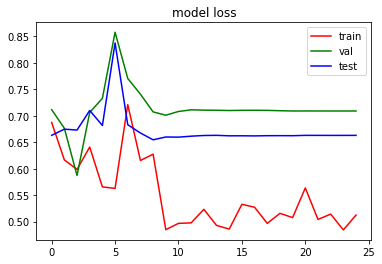

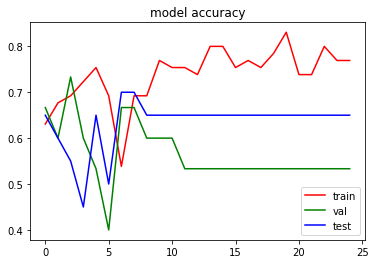

In [18]:
model_conv1,best_acc1= train_model(model_conv1, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
val_bestacc.append(best_acc1)

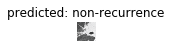

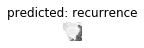

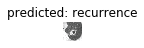

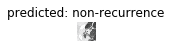

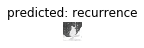

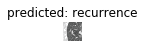

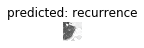

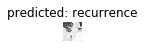

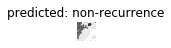

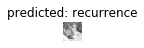

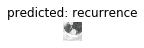

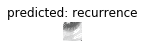

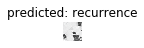

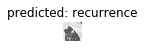

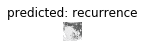

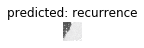

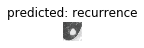

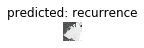

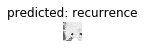

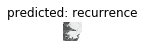

In [19]:
visualize_model2(model_conv1, num_images=20)

In [20]:
test_bestacc1=test_acc(model_conv1)
test_bestacc.append(test_bestacc1)

Testset Accuracy: 55 %


In [21]:
#freezen 1-2 conv layer
model_conv2 = torchvision.models.alexnet(pretrained=True)
for cnt in range(conv_layer[1]+1):
    for param in model_conv2.features[cnt].parameters():
        param.requires_grad = False
        print(cnt,model_conv2.features[cnt],': freeze')

num_ftrs = model_conv2.classifier[6].in_features
model_conv2.classifier[6] = nn.Linear(num_ftrs, 2)

model_conv2= model_conv2.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, model_conv2.parameters()), lr=learning_rate, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)) : freeze
0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)) : freeze
3 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) : freeze
3 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) : freeze


Epoch 0/24
----------
train Loss: 0.7313 Acc: 0.6615
val Loss: 0.6669 Acc: 0.6667
test Loss: 0.5797 Acc: 0.7000

Epoch 1/24
----------
train Loss: 0.6649 Acc: 0.6308
val Loss: 0.7886 Acc: 0.6667
test Loss: 0.5960 Acc: 0.7000

Epoch 2/24
----------
train Loss: 0.7862 Acc: 0.6769
val Loss: 0.7048 Acc: 0.6000
test Loss: 0.6427 Acc: 0.6500

Epoch 3/24
----------
train Loss: 0.6182 Acc: 0.6615
val Loss: 0.7389 Acc: 0.6667
test Loss: 0.6815 Acc: 0.5500

Epoch 4/24
----------
train Loss: 0.6092 Acc: 0.6769
val Loss: 0.7429 Acc: 0.6000
test Loss: 0.6715 Acc: 0.6500

Epoch 5/24
----------
train Loss: 0.5965 Acc: 0.6769
val Loss: 0.6989 Acc: 0.6667
test Loss: 0.6799 Acc: 0.6500

Epoch 6/24
----------
train Loss: 0.5998 Acc: 0.7231
val Loss: 0.7240 Acc: 0.6667
test Loss: 0.6801 Acc: 0.7000

Epoch 7/24
----------
train Loss: 0.5806 Acc: 0.7077
val Loss: 0.7118 Acc: 0.6000
test Loss: 0.6769 Acc: 0.6500

Epoch 8/24
----------
train Loss: 0.5570 Acc: 0.7538
val Loss: 0.6972 Acc: 0.6000
test Loss: 0.6

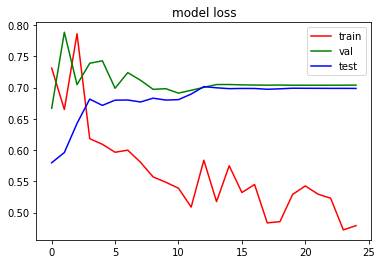

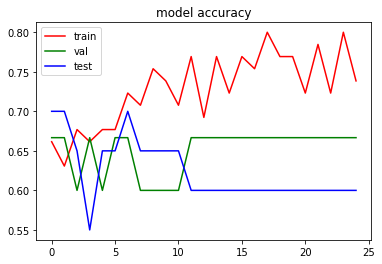

In [23]:
model_conv2,best_acc2= train_model(model_conv2, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
val_bestacc.append(best_acc2)

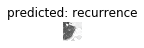

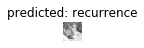

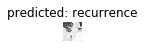

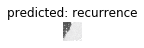

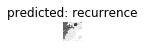

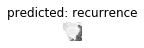

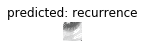

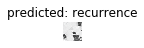

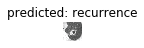

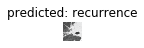

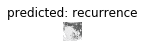

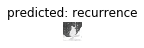

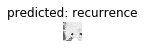

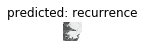

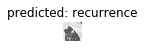

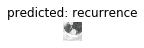

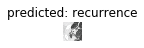

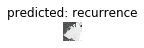

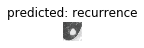

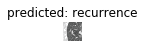

In [24]:
visualize_model2(model_conv2, num_images=20)

In [25]:
test_bestacc2=test_acc(model_conv2)
test_bestacc.append(test_bestacc2)

Testset Accuracy: 70 %


In [26]:
#freeze 1-3 conv layer
model_conv3 = torchvision.models.alexnet(pretrained=True)
for cnt in range(conv_layer[2]+1):
    for param in model_conv3.features[cnt].parameters():
        param.requires_grad = False
        print(cnt,model_conv3.features[cnt],': freeze')

num_ftrs = model_conv3.classifier[6].in_features
model_conv3.classifier[6] = nn.Linear(num_ftrs, 2)

model_conv3= model_conv3.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, model_conv3.parameters()), lr=learning_rate, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)) : freeze
0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)) : freeze
3 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) : freeze
3 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) : freeze
6 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) : freeze
6 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) : freeze


In [ ]:
model_conv3,best_acc3 = train_model(model_conv3, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
val_bestacc.append(best_acc3)

Epoch 0/24
----------
train Loss: 0.6852 Acc: 0.6000
val Loss: 0.8951 Acc: 0.5333
test Loss: 0.6981 Acc: 0.7000

Epoch 1/24
----------
train Loss: 0.6558 Acc: 0.6308
val Loss: 0.8949 Acc: 0.5333
test Loss: 0.7387 Acc: 0.7000

Epoch 2/24
----------
train Loss: 0.6476 Acc: 0.6769
val Loss: 0.8528 Acc: 0.4000
test Loss: 0.7601 Acc: 0.6000

Epoch 3/24
----------
train Loss: 0.6301 Acc: 0.6769
val Loss: 0.7757 Acc: 0.5333
test Loss: 0.6994 Acc: 0.7000

Epoch 4/24
----------
train Loss: 0.5647 Acc: 0.7231
val Loss: 0.7971 Acc: 0.4667
test Loss: 0.7019 Acc: 0.7000

Epoch 5/24
----------
train Loss: 0.5684 Acc: 0.7692
val Loss: 0.8076 Acc: 0.4667
test Loss: 0.7221 Acc: 0.6500

Epoch 6/24
----------
train Loss: 0.5804 Acc: 0.6923
val Loss: 0.8514 Acc: 0.5333
test Loss: 0.7353 Acc: 0.7500

Epoch 7/24
----------
train Loss: 0.5877 Acc: 0.7231
val Loss: 0.8285 Acc: 0.5333
test Loss: 0.7230 Acc: 0.7000

Epoch 8/24
----------
train Loss: 0.5213 Acc: 0.7385
val Loss: 0.8148 Acc: 0.5333
test Loss: 0.7

In [ ]:
visualize_model2(model_conv3, num_images=20)

In [ ]:
test_bestacc3=test_acc(model_conv3)
test_bestacc.append(test_bestacc3)

In [ ]:
#freeze 1-4conv layer
model_conv4 = torchvision.models.alexnet(pretrained=True)
for cnt in range(conv_layer[3]+1):
    for param in model_conv4.features[cnt].parameters():
        param.requires_grad = False
        print(cnt,model_conv4.features[cnt],': freeze')

num_ftrs = model_conv4.classifier[6].in_features
model_conv4.classifier[6] = nn.Linear(num_ftrs, 2)

model_conv4= model_conv4.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, model_conv4.parameters()), lr=learning_rate, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv4,best_acc4= train_model(model_conv4, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
val_bestacc.append(best_acc4)

In [ ]:
visualize_model2(model_conv4, num_images=20)

In [ ]:
test_bestacc4=test_acc(model_conv4)
test_bestacc.append(test_bestacc4)

In [ ]:
#freeze 1-5conv layer
model_conv5 = torchvision.models.alexnet(pretrained=True)
for cnt in range(conv_layer[4]+1):
    for param in model_conv5.features[cnt].parameters():
        param.requires_grad = False
        print(cnt,model_conv5.features[cnt],': freeze')

num_ftrs = model_conv5.classifier[6].in_features
model_conv5.classifier[6] = nn.Linear(num_ftrs, 2)

model_conv5= model_conv5.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, model_conv5.parameters()), lr=learning_rate, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv5 ,best_acc5= train_model(model_conv5, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
val_bestacc.append(best_acc5)

In [ ]:
visualize_model2(model_conv5, num_images=20)

In [ ]:
test_bestacc5=test_acc(model_conv5)
test_bestacc.append(test_bestacc5)

In [ ]:
clf_layer=[]
for cnt in range(len(model_ft.classifier)):
    for param in model_ft.classifier[cnt].parameters():
        print(cnt,model_ft.classifier[cnt])
        clf_layer.append(cnt)
clf_layer=list(set(clf_layer))
print(clf_layer)

In [ ]:
#freeze 1-6conv layer
model_conv6 = torchvision.models.alexnet(pretrained=True)
for cnt in range(conv_layer[4]+1):
    for param in model_conv6.features[cnt].parameters():
        param.requires_grad = False
        print(cnt,model_conv6.features[cnt],': freeze')
        
for cnt in range(clf_layer[0]+1):
    for param in model_conv6.classifier[cnt].parameters():
        print(cnt,model_conv6.classifier[cnt],': freeze')
        param.requires_grad = False
        

num_ftrs = model_conv6.classifier[6].in_features
model_conv6.classifier[6] = nn.Linear(num_ftrs, 2)

model_conv6= model_conv6.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, model_conv6.parameters()), lr=learning_rate, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv6,best_acc6= train_model(model_conv6, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
val_bestacc.append(best_acc6)

In [ ]:
visualize_model2(model_conv6, num_images=20)

In [ ]:
test_bestacc6=test_acc(model_conv6)
test_bestacc.append(test_bestacc6)

In [ ]:
#freeze 1-7conv layer
model_conv7 = torchvision.models.alexnet(pretrained=True)
for cnt in range(conv_layer[4]+1):
    for param in model_conv7.features[cnt].parameters():
        param.requires_grad = False
        print(cnt,model_conv7.features[cnt],': freeze')
        
for cnt in range(clf_layer[1]+1):
    for param in model_conv7.classifier[cnt].parameters():
        print(cnt,model_conv7.classifier[cnt],': freeze')
        param.requires_grad = False
        

num_ftrs = model_conv7.classifier[6].in_features
model_conv7.classifier[6] = nn.Linear(num_ftrs, 2)

model_conv7= model_conv7.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, model_conv7.parameters()), lr=learning_rate, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv7,best_acc7 = train_model(model_conv7, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
val_bestacc.append(best_acc7)

In [ ]:
visualize_model2(model_conv7, num_images=20)

In [ ]:
test_bestacc7=test_acc(model_conv7)
test_bestacc.append(test_bestacc7)

In [ ]:
plt.xlabel('The number of  frozen layers')
plt.ylabel('Accuracy')
plt.plot(val_bestacc,'g',test_bestacc,'b')
plt.legend(['val','test'])